In [2]:
from py2neo import Node, Relationship, Graph, NodeMatcher, RelationshipMatcher, Subgraph
g = Graph('bolt://localhost:7687',auth=('neo4j','your password'), name = 'trkg')

In [5]:
import pandas as pd
import os
from glob import glob
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import utils.data_loader

# 参数化 batch_group（固定）
batch_group = "holiday_batches"  # 可选: "weekday_batches", "holiday_batches", "weekend_batches"

# 拥堵分类函数
def classify_congestion_road(v_acc):
    if v_acc > 8.33:
        return 'smooth'
    elif 5.56 <= v_acc <= 8.33:
        return 'light congestion'
    elif 2.78 <= v_acc < 5.56:
        return 'congestion'
    elif 1.38 <= v_acc < 2.78:
        return 'severe congestion'
    elif v_acc < 1.38:
        return 'severe+ congestion'
    return 'none'

# 颜色映射
color_map = {
    "smooth": "#38A700",
    "light congestion": "#B0E000",
    "congestion": "#FFFF00",
    "severe congestion": "#FFAA01",
    "severe+ congestion": "#FE0000"
}

# 获取 geometry 字典
def get_honeycomb_geometry_dict(honeycomb_names):
    name_list = sorted(set(int(name) for name in honeycomb_names))
    cypher_list = "[" + ", ".join(map(str, name_list)) + "]"
    query = f"""
    MATCH (h:honeycomb)
    WHERE h.name IN {cypher_list}
    RETURN h.name AS name, h.geometry AS geometry
    """
    results = g.run(query).data()
    return {int(row["name"]): row["geometry"] for row in results}

# 加载 CRS 文件
crs_path = r"D:/paper2/result/roadcrs.txt"
roadcrs = utils.data_loader.CRS_load(crs_path)

# 初始化统计列表
congestion_stats = []

# 循环绘制 Group 1–5
for group_index in range(1, 6):
    print(f"📍 正在处理 Group {group_index}...")

    # 路径构建
    global_path = fr"C:\DCLASS\myJupyter\paper2\shanghai_data_save\{batch_group}\{group_index}\global_avg"
    file_paths = glob(os.path.join(global_path, "*.parquet"))

    # 加载并合并所有数据
    df_global = pd.concat([pd.read_parquet(fp) for fp in file_paths], ignore_index=True)

    # 拥堵分类
    df_global['congestion_level'] = df_global['global_avg_speed'].apply(classify_congestion_road)

    # 获取 geometry
    honeycomb_ids = df_global["honeycomb_name"].unique()
    geometry_map = get_honeycomb_geometry_dict(honeycomb_ids)
    df_global["geometry"] = df_global["honeycomb_name"].map(geometry_map)
    df_global["geometry"] = df_global["geometry"].apply(wkt.loads)

    # 转为 GeoDataFrame
    gdf_global = gpd.GeoDataFrame(df_global, geometry="geometry", crs=roadcrs)

    # 拥堵等级统计
    level_counts = gdf_global["congestion_level"].value_counts()
    for level, count in level_counts.items():
        congestion_stats.append({
            "group_index": group_index,
            "congestion_level": level,
            "count": count
        })

    # 映射颜色
    gdf_global["color"] = gdf_global["congestion_level"].map(color_map)

    # 绘图
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_global.plot(color=gdf_global["color"], edgecolor=None, ax=ax)

    # 图例
    legend_patches = [
        mpatches.Patch(color=color_map[key], label=key.replace("_", " ").title())
        for key in color_map
    ]
    ax.legend(handles=legend_patches, title="Congestion Level")

    # 设置标题
    batch_group_short = batch_group.split('_')[0].capitalize()
    ax.set_title(f"{batch_group_short} mode - Group {group_index}", fontsize=14)
    ax.axis("off")

    # 保存图像
    output_dir = fr"C:\DCLASS\myJupyter\paper2\shanghai_data_save\{batch_group}"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"congestion_classification_map{group_index}.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

    print(f"✅ Group {group_index} 图像已保存至: {output_path}")


# 保存统计结果为 CSV
df_stats = pd.DataFrame(congestion_stats)
csv_output_path = fr"C:\DCLASS\研究生之路\paper2\congestion_statistics_{batch_group}.csv"
df_stats.to_csv(csv_output_path, index=False, encoding="utf-8-sig")

print(f"📄 拥堵统计已保存为 CSV: {csv_output_path}")

📍 正在处理 Group 1...
✅ Group 1 图像已保存至: C:\DCLASS\myJupyter\paper2\shanghai_data_save\holiday_batches\congestion_classification_map1.png
📍 正在处理 Group 2...
✅ Group 2 图像已保存至: C:\DCLASS\myJupyter\paper2\shanghai_data_save\holiday_batches\congestion_classification_map2.png
📍 正在处理 Group 3...
✅ Group 3 图像已保存至: C:\DCLASS\myJupyter\paper2\shanghai_data_save\holiday_batches\congestion_classification_map3.png
📍 正在处理 Group 4...
✅ Group 4 图像已保存至: C:\DCLASS\myJupyter\paper2\shanghai_data_save\holiday_batches\congestion_classification_map4.png
📍 正在处理 Group 5...
✅ Group 5 图像已保存至: C:\DCLASS\myJupyter\paper2\shanghai_data_save\holiday_batches\congestion_classification_map5.png
📄 拥堵统计已保存为 CSV: C:\DCLASS\研究生之路\paper2\congestion_statistics_holiday_batches.csv


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# 读取 Excel 数据
file_path = r"C:\DCLASS\研究生之路\paper2\congestion_level.xlsx"
df = pd.read_excel(file_path)

# 输出图像目录
output_dir = r"C:\DCLASS\研究生之路\paper2\画图"
os.makedirs(output_dir, exist_ok=True)

# 拥堵等级
target_levels = ["congestion", "severe congestion", "severe+ congestion"]
colors = {
    "holiday": "#66C2A5",
    "weekday": "#FFD700",
    "weekend": "#FC8D62"
}

# 创建基础 group_index
group_index = sorted(df["group_index_holiday"].unique())
combined_df = pd.DataFrame({"group_index": group_index})

# 合并三种模式数据
for mode in ["holiday", "weekday", "weekend"]:
    col_index = f"group_index_{mode}"
    col_level = f"congestion_level_{mode}"
    col_count = f"count_{mode}"

    df_mode = df[df[col_level].isin(target_levels)]
    pivot = df_mode.pivot(index=col_index, columns=col_level, values=col_count).reset_index()
    pivot = pivot.rename(columns={col_index: "group_index"})
    pivot.columns = [f"{mode}_{col}" if col != "group_index" else col for col in pivot.columns]

    combined_df = pd.merge(combined_df, pivot, on="group_index", how="left")

# 为每个拥堵等级绘制柱状图
bar_width = 0.2
x = np.arange(len(group_index))  # x位置

for level in target_levels:
    plt.figure(figsize=(8, 5))
    for i, mode in enumerate(["holiday", "weekday", "weekend"]):
        col = f"{mode}_{level}"
        if col in combined_df.columns:
            offset = (i - 1) * bar_width  # 居中
            plt.bar(
                x + offset,
                combined_df[col],
                width=bar_width,
                label=mode.title(),
                color=colors[mode]
            )

    plt.title(f"{level.title()}", fontsize=14)
    plt.xlabel("Group Index", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(x, group_index)
    plt.legend()

    # 美化边框
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.tight_layout()
    # plt.show()


    # 保存图像
    filename = f"{level.replace(' ', '_')}.png"
    save_path = os.path.join(output_dir, filename)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"✅ 已保存: {save_path}")

✅ 已保存: C:\DCLASS\研究生之路\paper2\画图\congestion.png
✅ 已保存: C:\DCLASS\研究生之路\paper2\画图\severe_congestion.png
✅ 已保存: C:\DCLASS\研究生之路\paper2\画图\severe+_congestion.png


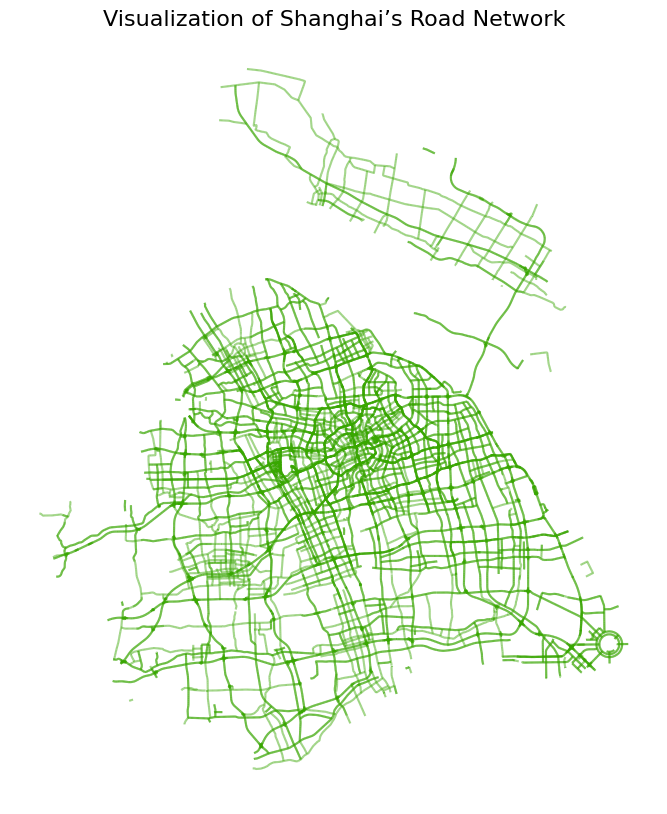

✅ 图像已保存至：C:\DCLASS\研究生之路\paper2\画图\split_result.png


In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 读取 SHP 文件
shp_path = r"D:\paper2\result\split_result.shp"
gdf = gpd.read_file(shp_path)

# 绘图
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, edgecolor='#38A700', alpha=0.5)

# 设置标题、关闭坐标轴
ax.set_title("Visualization of Shanghai’s Road Network", fontsize=16)
ax.axis("off")

# 保存图像
output_path = r"C:\DCLASS\研究生之路\paper2\画图\split_result.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"✅ 图像已保存至：{output_path}")
